# Первая часть дз

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

'1.13.1'

In [3]:
from tqdm import tqdm
from numpy.random import randn

import pathlib
import random
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
data_root = pathlib.Path('utk_faces_done')
print(data_root)

utk_faces_done


In [6]:
for item in data_root.iterdir():
      print(item)

utk_faces_done\females
utk_faces_done\males


In [7]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

2290

In [8]:
all_image_paths[:10]

['utk_faces_done\\males\\18_0_3_20170104225805617.jpg.chip.jpg',
 'utk_faces_done\\females\\22_1_2_20170116220943302.jpg.chip.jpg',
 'utk_faces_done\\males\\17_0_0_20170104011953696.jpg.chip.jpg',
 'utk_faces_done\\males\\25_0_1_20170113145218790.jpg.chip.jpg',
 'utk_faces_done\\males\\17_0_0_20170105183607439.jpg.chip.jpg',
 'utk_faces_done\\females\\20_1_0_20170117141358391.jpg.chip.jpg',
 'utk_faces_done\\males\\24_0_0_20170113210127140.jpg.chip.jpg',
 'utk_faces_done\\females\\21_1_0_20170111182452742.jpg.chip.jpg',
 'utk_faces_done\\males\\24_0_1_20170117170559987.jpg.chip.jpg',
 'utk_faces_done\\females\\18_1_0_20170109213413212.jpg.chip.jpg']

## Inspect the images
Now let's have a quick look at a couple of the images, so we know what we're dealing with:

In [9]:
import IPython.display as display

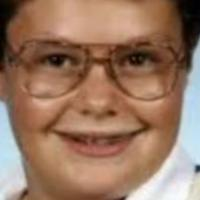

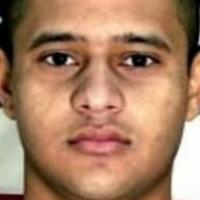

In [10]:
for n in range(2):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

## Determine the label for each image

In [9]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['females', 'males']

In [10]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'females': 0, 'males': 1}

First 5 labels indices:  [0, 0, 1, 1, 1]


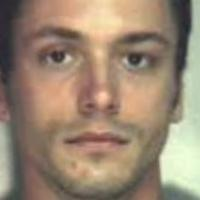

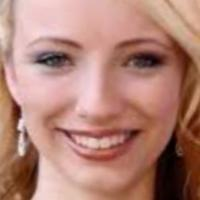

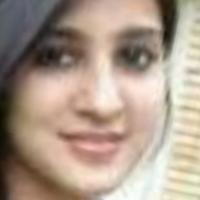

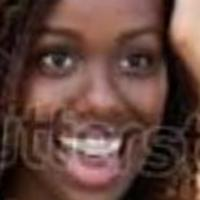

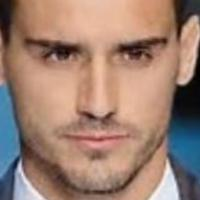

In [11]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 5 labels indices: ", all_image_labels[:5])


list = ['utk_faces_done\\males\\20_0_0_20170120133547085.jpg.chip.jpg',
 'utk_faces_done\\females\\19_1_0_20170103162951552.jpg.chip.jpg',
 'utk_faces_done\\females\\22_1_3_20170104223452679.jpg.chip.jpg',
 'utk_faces_done\\females\\22_1_1_20170112214852574.jpg.chip.jpg',
 'utk_faces_done\\males\\25_0_0_20170119171142840.jpg.chip.jpg']

for n in range(5):
  image_path_10 = all_image_paths[:5]
  display.display(display.Image(list[n]))
  print()

In [12]:
img_path = all_image_paths[0]
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [13]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(200, 200, 3)
<dtype: 'uint8'>


In [14]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


In [15]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [16]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

In [17]:
# %matplotlib inline
# image_path = all_image_paths[0]
# label = all_image_labels[0]

# plt.imshow(load_and_preprocess_image(img_path))
# plt.grid(False)
# plt.title(label_names[label].title())
# print()

## Build a tf.data.Dataset

In [18]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [21]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

## A dataset of (image, label) pairs

In [22]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [23]:
print(label_ds)

<DatasetV1Adapter shapes: (), types: tf.int64>


In [24]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

Instructions for updating:
Colocations handled automatically by placer.
females
females
males
males
males
females
males
females
males
females


In [25]:
# First, build a TFRecord file from the raw image data:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

# Вторая часть дз

In [26]:
#Next build a dataset that reads from the TFRecord file and decodes/reformats the images using the preprocess_image function we defined earlier.
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

In [27]:
print(image_ds)

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>


In [28]:
# plt.figure(figsize=(8,8))
# for n,image in enumerate(image_ds.take(4)):
#   plt.subplot(2,2,n+1)
#   plt.imshow(image)
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])
#   plt.show()

In [28]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [88]:
print(image_label_ds)

TypeError: 'DatasetV1Adapter' object is not callable

## Basic methods for training
To train a model with this dataset you will want the data:
To be well shuffled.
To be batched.
To repeat forever.
Batches to be available as soon as possible.
These features can be easily added using the tf.data api.

In [39]:
BATCH_SIZE = 16

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [74]:
import keras

# pretrained_net = tf.keras.applications.mobilenet.MobileNet(input_shape=(192, 192, 3), include_top=False)
pretrained_net = tf.keras.applications.mobilenet.MobileNet(input_shape=(192, 192, 3), dropout=9e-4, include_top=False, weights='imagenet')
pretrained_net.trainable=True

In [75]:
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

In [76]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [77]:
print(image_batch[:1])
print(label_batch)

tf.Tensor(
[[[[-0.46666664 -0.372549   -0.38823527]
   [-0.48431373 -0.39117646 -0.42222226]
   [-0.5346405  -0.4653595  -0.49150324]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-0.48300654 -0.3888889  -0.40522873]
   [-0.50032675 -0.4071896  -0.4388889 ]
   [-0.5431372  -0.47385627 -0.5144063 ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-0.49934644 -0.40522873 -0.43660128]
   [-0.5160403  -0.4235022  -0.456536  ]
   [-0.5594771  -0.48959696 -0.5325708 ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  ...

  [[-0.8245098  -0.87941176 -0.9578431 ]
   [-0.8169526  -0.8715278  -0.9506127 ]
   [-0.82491827 -0.8719771  -0.9660948 ]
   ...
   [ 0.5205883  -0.09901959 -0.5617647 ]
   [ 0.5177288  -0.10187906 -0.5502453 ]
   [ 

In [78]:
feature_map_batch = pretrained_net(image_batch)
print(feature_map_batch.shape)

(16, 6, 6, 1024)


In [79]:
model = tf.keras.Sequential([
  pretrained_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [80]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [81]:
len(model.trainable_variables)

83

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_192 (Model)   (None, 6, 6, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [83]:
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

144.0

In [84]:
%%time
count=1
n=1
while count <= n:
  print ("Цикл ",count," / ",n)
  history = model.fit(ds, epochs=8, steps_per_epoch=12, use_multiprocessing=True, verbose=1)   
  count=count+1

from keras.models import load_model
model.save('dz_sex_model.h5')

Цикл  1  /  1
Epoch 1/8
12/12 [==============================] - ETA: 5:49 - loss: 6.1245 - acc: 0.500 - ETA: 4:00 - loss: 6.5572 - acc: 0.531 - ETA: 3:09 - loss: 6.3398 - acc: 0.500 - ETA: 2:36 - loss: 5.5679 - acc: 0.531 - ETA: 2:10 - loss: 5.1358 - acc: 0.537 - ETA: 1:48 - loss: 4.5030 - acc: 0.552 - ETA: 1:27 - loss: 3.9197 - acc: 0.571 - ETA: 1:08 - loss: 3.8400 - acc: 0.570 - ETA: 50s - loss: 3.5881 - acc: 0.576 - ETA: 32s - loss: 3.4828 - acc: 0.59 - ETA: 16s - loss: 3.3050 - acc: 0.59 - 194s 16s/step - loss: 3.2370 - acc: 0.5990
Epoch 2/8
12/12 [==============================] - ETA: 2:49 - loss: 0.6931 - acc: 0.687 - ETA: 2:34 - loss: 0.6282 - acc: 0.718 - ETA: 2:17 - loss: 1.2637 - acc: 0.708 - ETA: 2:01 - loss: 1.0669 - acc: 0.750 - ETA: 1:45 - loss: 0.9835 - acc: 0.775 - ETA: 1:27 - loss: 1.0813 - acc: 0.729 - ETA: 1:10 - loss: 1.2928 - acc: 0.732 - ETA: 56s - loss: 1.2159 - acc: 0.718 - ETA: 43s - loss: 1.1518 - acc: 0.71 - ETA: 29s - loss: 1.2930 - acc: 0.71 - ETA: 14s - 

In [85]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


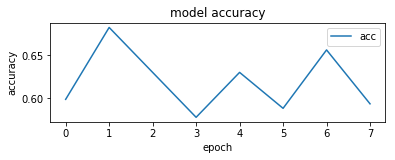

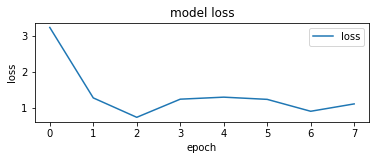

In [86]:
plt.figure(1) 
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['acc']) 
plt.show()

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['loss'], loc='upper right') 
plt.show()

In [90]:
predicts = model.predict(image_ds, steps=2).data();

ValueError: Error when checking input: expected mobilenet_1.00_192_input to have 4 dimensions, but got array with shape (192, 192, 3)

In [96]:
preprocess_image('18_1_4_20170117193229357.jpg')

InvalidArgumentError: Expected image (JPEG, PNG, or GIF), got unknown format starting with '18_1_4_201701171' [Op:DecodeJpeg]

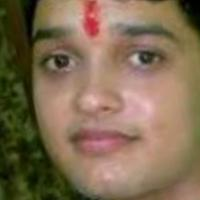

In [19]:
image_path = all_image_paths[0]
display.display(display.Image(image_path))